<a href="https://colab.research.google.com/github/PathanZeba/EV-Market-Analysis/blob/main/EV_India_Market_Segmentation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

In [4]:
# Load dataset
df = pd.read_csv("/content/Indian automobile buying behavour study 1.0.csv")

In [5]:
# Problem Breakdown (Fermi Estimation)

# Assuming 10 lakh urban Indian households buy a new vehicle every year.
# Estimate that 10% (~1 lakh) consider EVs.
# We aim to target ~10% of EV intenders = 10,000 customers initially.
# Average vehicle price ~ ₹8,00,000.
# Estimated profit margin per vehicle ~ ₹80,000 (10%).
# So, early market profit = 10,000 * ₹80,000 = ₹80 Crores.

***Data Exploration***

In [6]:
df.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,House Loan,Wife Working,Salary,Wife Salary,Total Salary,Make,Price
0,27,Salaried,Single,Post Graduate,0,Yes,No,No,800000,0,800000,i20,800000
1,35,Salaried,Married,Post Graduate,2,Yes,Yes,Yes,1400000,600000,2000000,Ciaz,1000000
2,45,Business,Married,Graduate,4,Yes,Yes,No,1800000,0,1800000,Duster,1200000
3,41,Business,Married,Post Graduate,3,No,No,Yes,1600000,600000,2200000,City,1200000
4,31,Salaried,Married,Post Graduate,2,Yes,No,Yes,1800000,800000,2600000,SUV,1600000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               99 non-null     int64 
 1   Profession        99 non-null     object
 2   Marrital Status   99 non-null     object
 3   Education         99 non-null     object
 4   No of Dependents  99 non-null     int64 
 5   Personal loan     99 non-null     object
 6   House Loan        99 non-null     object
 7   Wife Working      99 non-null     object
 8   Salary            99 non-null     int64 
 9   Wife Salary       99 non-null     int64 
 10  Total Salary      99 non-null     int64 
 11  Make              99 non-null     object
 12  Price             99 non-null     int64 
dtypes: int64(6), object(7)
memory usage: 10.2+ KB


In [8]:
df.describe()

,Age,No of Dependents,Salary,Wife Salary,Total Salary,Price
count,99.000000,99.000000,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01
mean,36.313131,2.181818,1.736364e+06,5.343434e+05,2.270707e+06,1.194040e+06
std,6.246054,1.335265,6.736217e+05,6.054450e+05,1.050777e+06,4.376955e+05
min,26.000000,0.000000,2.000000e+05,0.000000e+00,2.000000e+05,1.100000e+05
25%,31.000000,2.000000,1.300000e+06,0.000000e+00,1.550000e+06,8.000000e+05
50%,36.000000,2.000000,1.600000e+06,5.000000e+05,2.100000e+06,1.200000e+06
75%,41.000000,3.000000,2.200000e+06,9.000000e+05,2.700000e+06,1.500000e+06
max,51.000000,4.000000,3.800000e+06,2.100000e+06,5.200000e+06,3.000000e+06


In [9]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)

Shape: (99, 13)

Columns:
 Index(['Age', 'Profession', 'Marrital Status', 'Education', 'No of Dependents',
       'Personal loan', 'House Loan', 'Wife Working', 'Salary', 'Wife Salary',
       'Total Salary', 'Make', 'Price'],
      dtype='object')


In [10]:
print("\nData types:\n", df.dtypes)


Data types:
 Age                  int64
Profession          object
Marrital Status     object
Education           object
No of Dependents     int64
Personal loan       object
House Loan          object
Wife Working        object
Salary               int64
Wife Salary          int64
Total Salary         int64
Make                object
Price                int64
dtype: object


***Data Cleaning***

In [11]:
# Handle missing values
missing = df.isnull().sum()
print("\nMissing values per column:\n", missing)


Missing values per column:
 Age                 0
Profession          0
Marrital Status     0
Education           0
No of Dependents    0
Personal loan       0
House Loan          0
Wife Working        0
Salary              0
Wife Salary         0
Total Salary        0
Make                0
Price               0
dtype: int64


In [12]:
# If missing values found in 'Price' or 'Salary'
if df['Price'].isnull().sum() > 0:
    df['Price'].fillna(df['Price'].mean(), inplace=True)

if df['Salary'].isnull().sum() > 0:
    df['Salary'].fillna(df['Salary'].mean(), inplace=True)

In [13]:
# Remove duplicates and correct data types
df.drop_duplicates(inplace=True)
df['No of Dependents'] = df['No of Dependents'].astype(int)

***Feature Engineering***

In [14]:
# Income_Category from Total Salary
def categorize_income(salary):
    if salary < 1000000:
        return 'Low'
    elif salary < 2000000:
        return 'Medium'
    else:
        return 'High'

df['Income_Category'] = df['Total Salary'].apply(categorize_income)


In [15]:
# Vehicle_Type from Make
def get_vehicle_type(make):
    make = make.lower()
    if make in ['i20', 'alto', 'swift', 'wagonr', 'baleno']:
        return 'Hatchback'
    elif make in ['ciaz', 'city', 'verna']:
        return 'Sedan'
    elif make in ['duster', 'suv', 'creata', 'xuv', 'scorpio']:
        return 'SUV'
    elif make in ['fortuner', 'endeavour', 'luxuray']:
        return 'Luxury'
    else:
        return 'Other'

df['Vehicle_Type'] = df['Make'].apply(get_vehicle_type)


In [16]:
# both functions
df['Income_Category'] = df['Total Salary'].apply(categorize_income)
df['Vehicle_Type'] = df['Make'].apply(get_vehicle_type)

***Data Visualization***

/tmp/ipython-input-17-909239019.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Income_Category', palette='Set2')


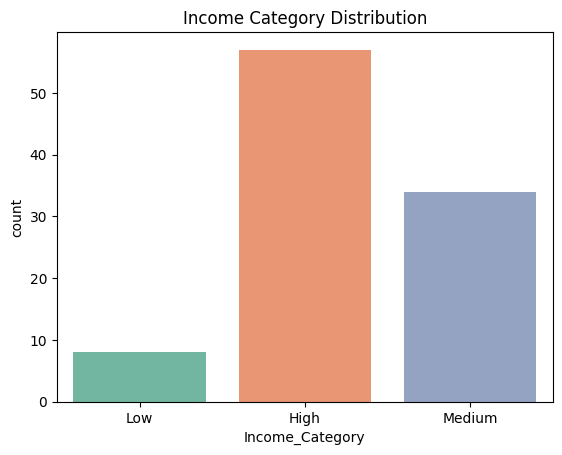

In [17]:
sns.countplot(data=df, x='Income_Category', palette='Set2')
plt.title("Income Category Distribution")
plt.show()

/tmp/ipython-input-18-759026550.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Vehicle_Type', palette='Set3')


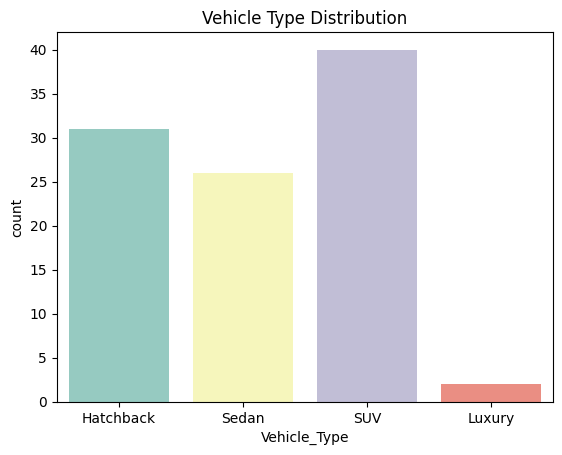

In [18]:
sns.countplot(data=df, x='Vehicle_Type', palette='Set3')
plt.title("Vehicle Type Distribution")
plt.show()

/tmp/ipython-input-19-2453170144.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Income_Category', y='Price', palette='Set1')


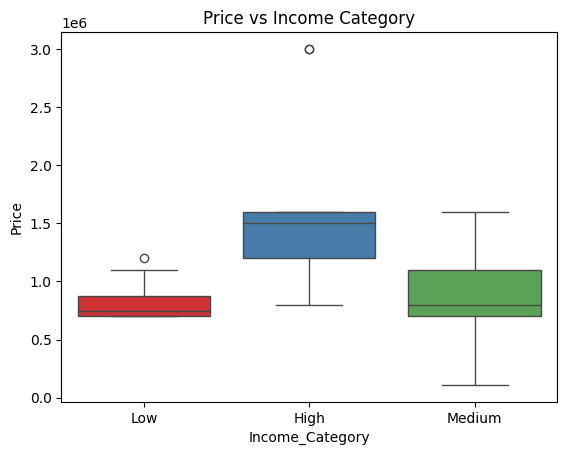

In [19]:
sns.boxplot(data=df, x='Income_Category', y='Price', palette='Set1')
plt.title("Price vs Income Category")
plt.show()

***Encode Categorical Data***

In [20]:
le = LabelEncoder()
df['Income_encoded'] = le.fit_transform(df['Income_Category'])
df['Make_encoded'] = le.fit_transform(df['Make'])

***Clustering (Elbow Method)***

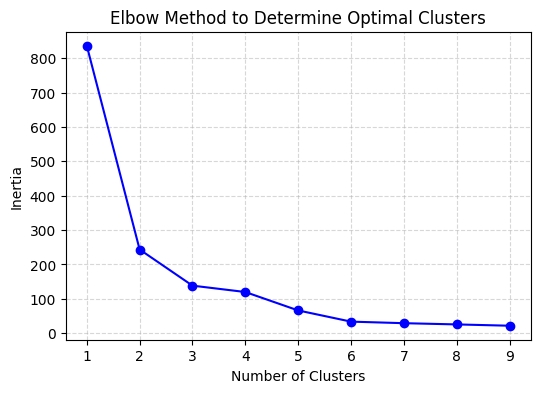

In [21]:
X = df[['Income_encoded', 'Make_encoded']]
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1, 10), inertia, marker='o', color='blue')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

***Final Clustering***

In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

print(df[['Income_Category', 'Make', 'Cluster']].head())

  Income_Category    Make  Cluster
0             Low     i20        1
1            High    Ciaz        0
2          Medium  Duster        0
3            High    City        0
4            High     SUV        1


***Visualizations of Clusters***

/tmp/ipython-input-23-4025897075.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Make', palette='tab20')


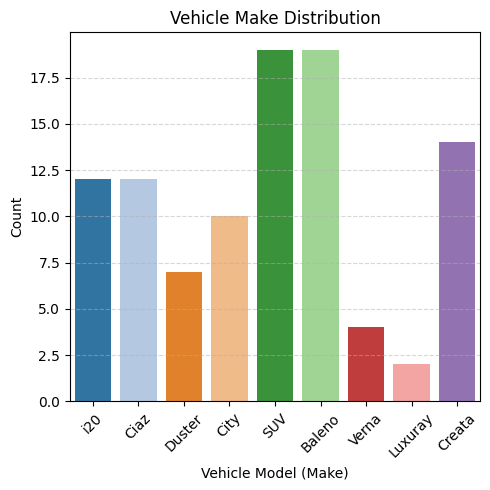

In [23]:
plt.figure(figsize=(5,5))
sns.countplot(data=df, x='Make', palette='tab20')
plt.title("Vehicle Make Distribution")
plt.xlabel("Vehicle Model (Make)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

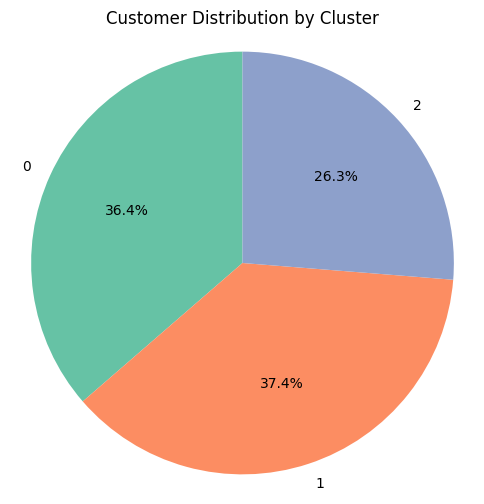

In [24]:
# Customer Distribution
cluster_counts = df['Cluster'].value_counts().sort_index()
plt.figure(figsize=(6,6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('Set2'))
plt.title('Customer Distribution by Cluster')
plt.axis('equal')
plt.show()

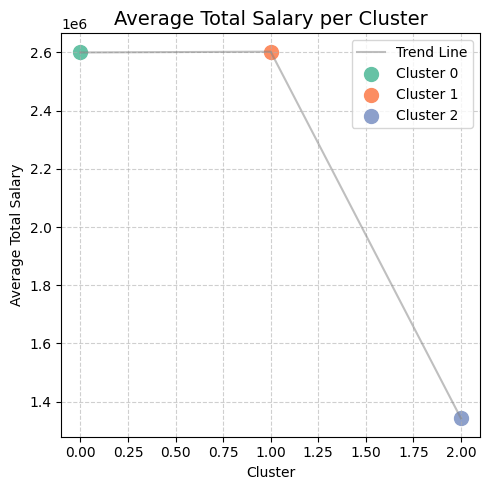

In [25]:
# Average Salary per Cluster

salary_mean = df.groupby('Cluster')['Total Salary'].mean().reset_index()

colors = sns.color_palette('Set2', n_colors=len(salary_mean))

plt.figure(figsize=(5, 5))
plt.plot(salary_mean['Cluster'], salary_mean['Total Salary'], linestyle='-', color='gray', alpha=0.5, label='Trend Line')

for i in range(len(salary_mean)):
    plt.scatter(salary_mean['Cluster'][i], salary_mean['Total Salary'][i],
                color=colors[i], s=100, label=f"Cluster {salary_mean['Cluster'][i]}")

plt.title("Average Total Salary per Cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Average Total Salary")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

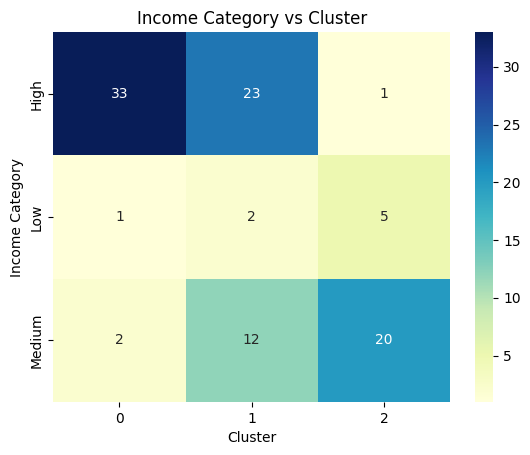

In [26]:
# Income vs Cluster
ct = pd.crosstab(df['Income_Category'], df['Cluster'])
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Income Category vs Cluster")
plt.xlabel("Cluster")
plt.ylabel("Income Category")
plt.show()

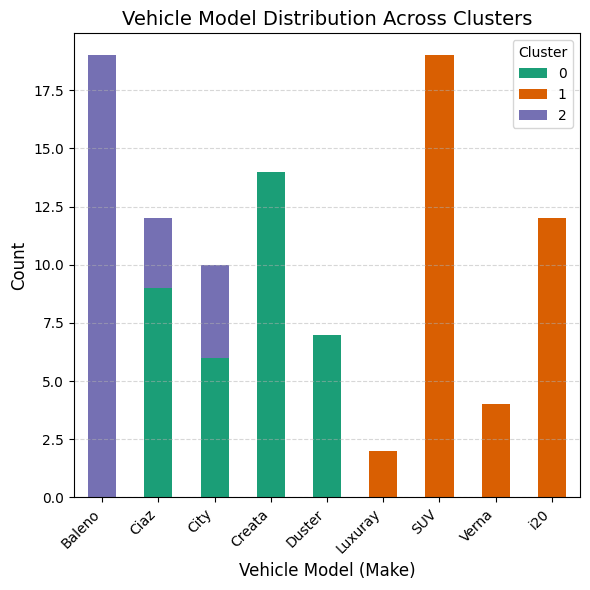

In [27]:
# Make vs Cluster
ct = pd.crosstab(df['Make'], df['Cluster'])
colors = plt.get_cmap('Dark2').colors
ct.plot(kind='bar', stacked=True, color=colors, figsize=(6,6))
plt.title("Vehicle Model Distribution Across Clusters", fontsize=14)
plt.xlabel("Vehicle Model (Make)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title='Cluster')
plt.show()

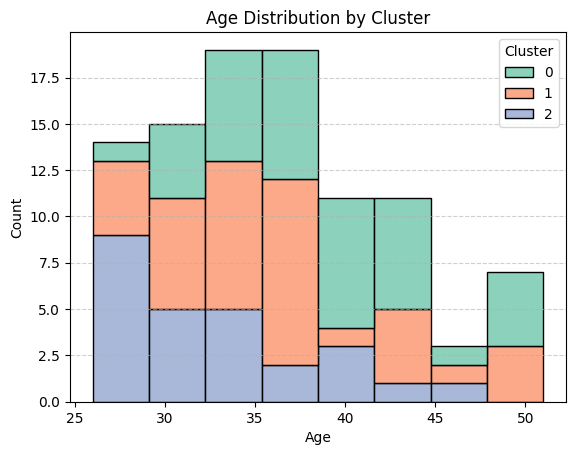

In [28]:
# Age Distribution by Cluster
sns.histplot(data=df, x='Age', hue='Cluster', multiple='stack', palette='Set2')
plt.title("Age Distribution by Cluster")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

***Market Profit Estimation***

In [29]:
# Assuming 10,000 early adopters in our target segment.
# Price per vehicle: ₹8,00,000, Profit margin: ₹80,000 per vehicle
potential_customers = 10000
price_per_vehicle = 800000
profit_margin_per_vehicle = 80000
potential_profit = potential_customers * profit_margin_per_vehicle
print(f"Estimated early market profit: ₹{potential_profit:,}")

Estimated early market profit: ₹800,000,000


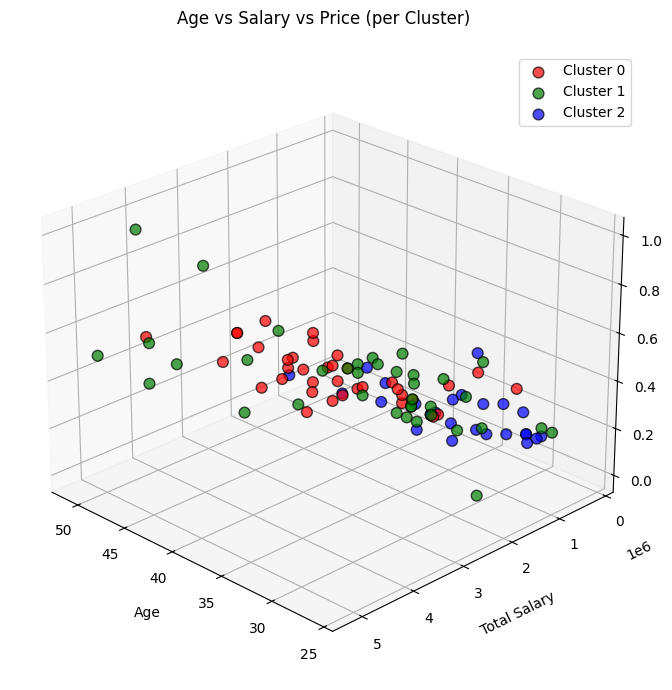

In [30]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Price_scaled']] = scaler.fit_transform(df[['Price']])

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'blue']

for i in range(3):
    subset = df[df['Cluster'] == i]
    ax.scatter(
        subset['Age'],
        subset['Total Salary'],
        subset['Price_scaled'],
        label=f'Cluster {i}',
        alpha=0.7,
        color=colors[i],
        edgecolor='k',
        s=60
    )

ax.set_xlabel('Age', labelpad=10)
ax.set_ylabel('Total Salary', labelpad=10)
ax.set_zlabel('Price (scaled)', labelpad=10)
ax.set_title("Age vs Salary vs Price (per Cluster)", pad=20)
ax.view_init(elev=25, azim=135)
ax.legend()
plt.tight_layout()
plt.show()



In [31]:
# Conclusion

print(" FINAL INSIGHTS:")

# Cluster-wise Summary
for i in sorted(df['Cluster'].unique()):
    subset = df[df['Cluster'] == i]
    avg_salary = round(subset['Total Salary'].mean(), 2)
    popular_make = subset['Make'].mode()[0]
    income_group = subset['Income_Category'].mode()[0]
    vehicle_type = subset['Vehicle_Type'].mode()[0]

    print(f"\n Cluster {i} Summary:")
    print(f"   • Average Salary: ₹{avg_salary}")
    print(f"   • Most Common Income Group: {income_group}")
    print(f"   • Most Preferred Vehicle Type: {vehicle_type}")
    print(f"   • Popular Make: {popular_make}")

 FINAL INSIGHTS:

 Cluster 0 Summary:
   • Average Salary: ₹2600000.0
   • Most Common Income Group: High
   • Most Preferred Vehicle Type: SUV
   • Popular Make: Creata

 Cluster 1 Summary:
   • Average Salary: ₹2602702.7
   • Most Common Income Group: High
   • Most Preferred Vehicle Type: SUV
   • Popular Make: SUV

 Cluster 2 Summary:
   • Average Salary: ₹1342307.69
   • Most Common Income Group: Medium
   • Most Preferred Vehicle Type: Hatchback
   • Popular Make: Baleno
